# Autoencoder and Variational Autoencoder

本單元，我們將介紹並帶各位同學實作非監督式學習中的自編碼器及其變形。

## 1. 初始準備

In [1]:
%env keras=Tensorflow

env: keras=Tensorflow


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, FloatSlider

In [3]:
from keras.models import Sequential,Model
from keras.layers import Input,Lambda
from keras.layers import Dense #NN
from keras.layers import Conv2D,MaxPooling2D #CNN
from keras.optimizers import SGD,Adam
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils
from keras import backend as k

C:\Users\w8462\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 2. 讀入 MNIST 數據庫
老規矩，開場就先召喚我們的好朋友 - MNIST 手寫數字數據庫

In [4]:
(x_train0,y_train0),(x_test0,y_test0)=mnist.load_data()

調整資料長相及單位化

In [5]:
x_train=x_train0.reshape(60000,-1) #-1為numpy自動計算
x_test=x_test0.reshape(10000,-1) #-1為numpy自動計算

x_train-=x_train.min()
x_train=x_train/x_train.max()

x_test-=x_test.min()
x_test=x_test/x_test.max()


# 3. Autoencoder

Autoencoder，又稱為自編碼器，是一個將資料壓縮再還原的模型，通常由一編碼器及一解碼器所組成。

給定一組數據集 $\mathcal{D}\subseteq\mathbb{R}^n$ 以及一個壓縮維度 $m$，其中 $m < n$。

數學上來說表示，Autoencoder 由 $\mbox{Enc}:\mathbb{R}^n\to\mathbb{R}^m$ 和 $\mbox{Dec}:\mathbb{R}^m\to\mathbb{R}^n$ 所構成：

$$ \mathbb{R}^n \overset{\mbox{Enc}}{\to} \mathbb{R}^m \overset{\mbox{Dec}}{\to} \mathbb{R}^n$$

$$ x \overset{\mbox{Enc}}{\mapsto} h \overset{\mbox{Dec}}{\mapsto} \hat{x} $$

且對於任意的 $x\in\mathcal{D}$，我們希望 $x\approx\hat{x} = Dec(h) = Dec\big(Enc(x)\big)$

其中，$h = \mbox{Enc}(x)$ 稱之 $x$ 為潛在表示法 (latent representation)，而 $\hat{x}$ 則是 $x$ 自編碼過後的還原資料。

換言之，我們希望原本的資料 $x$，經過函數 $\mbox{Enc}$ 編碼成維度比較小的資料 $h$，再透過函數 $\mbox{Dec}$ 還原成 $\hat{x}$。

一般而言，我們會希望 $\mbox{Enc}$ 和 $\mbox{Dec}$  看起來有點對稱。

**為了視覺化的目的，經常會考慮 $m=2$ 的狀況。**

## 3.1 Autoencoder 與手寫辨識資料 MNIST

我們考慮具有下列結構的 Autoencoder:

<img src="autoencoder.png" alt="drawing" style="width: 600px;"/>


為了方便，我們將三個變數的符號表示出來：

$$ x \overset{\mbox{Enc}}{\mapsto} h \overset{\mbox{Dec}}{\mapsto} \hat{x} $$

In [6]:
enc_1=Dense(100,activation='sigmoid')
enc_2=Dense(2,activation='sigmoid')

dec_2=Dense(100,activation='sigmoid')
dec_1=Dense(784,activation='sigmoid')

In [7]:
x=Input(shape=(784,))

h=enc_2(enc_1(x))

x_hat=dec_1(dec_2(h))

autoencoder=Model(x,x_hat)

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
_________________________________________________________________
dense_3 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_4 (Dense)              (None, 784)               79184     
Total params: 158,186
Trainable params: 158,186
Non-trainable params: 0
_________________________________________________________________


一樣的，當模型 compile 之後，便可以進行資料的訓練、預測等等，請有興趣的同學讀入 MNIST 手寫辨識之料後，自行完成這個模型的訓練。

In [8]:
autoencoder.compile(loss='mse',optimizer=Adam(lr=(1e-4)))

In [9]:
#autoencoder.fit(x_train,x_train,batch_size=1024,epochs=10)

如果覺得訓練太久的話，也可以使用我們準備好的權重。

In [10]:
autoencoder.load_weights('autoencoder_handwriting_model_weights.h5')

## 3.2 視覺化 - 子模型的取出
為了視覺化(及其他潛在應用)，我們也會從 Autoencoder 將 Encoder 和 Decoder 分別定義出來。

In [11]:
Encoder=Model(x,h)
Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


Decoder 是由 $h$ 開始，因此，我們先準備一個與 $h$ 相同大小的 `Input`，並餵進 `dec_2` 及 `dec_1` 中即可。

In [12]:
h_input=Input(shape=(2,))
Decoder=Model(h_input,dec_1(dec_2(h_input)))

Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_4 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


## 3.3 視覺化 - Encoder

首先，我們隨便抽取一張圖，並透過 Encoder 來算出它的 latent 表示。

In [13]:
index=5998
Encoder.predict(x_train[index:index+1])

array([[0.24474536, 0.11025778]], dtype=float32)

接者，我們從 $10000$ 筆測試資料隨機挑選 $3000$ 手寫辨識資料，將其轉換成 latent 表示法，並畫在同一平面上。

In [14]:
inds=np.random.randint(10000,size=3000)

In [15]:
latent=Encoder.predict(x_train[inds])
latent.shape


(3000, 2)

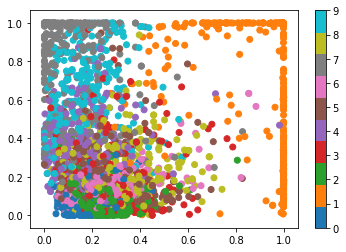

In [16]:
plt.scatter(latent[:,0],latent[:,1],c=y_train0[inds],cmap='tab10')
plt.colorbar()

### 2.4 視覺化 - Decoder

首先，我們在 $[0, 1]\times[0, 1]$ 這個單位正方形內均勻取樣 $15*15$ 個點，並將這 $225$ 個平面上的點，透過 Decoder 進行圖片的還原。

In [17]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)

In [18]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[(n-i-1) * digit_size: (n - i) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

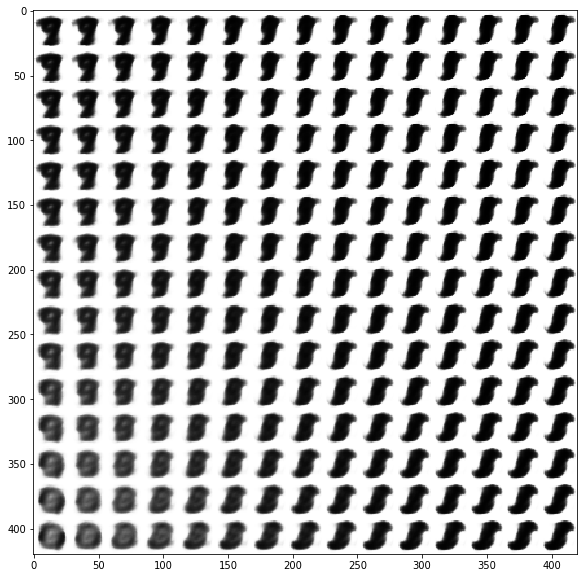

In [19]:
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys')
#plt.axis('off')
plt.show()

# 4.Variational Autoencoder
若每筆資料的 latent 不僅僅是一個**位置**，而是一個分布，且分布的平均值附近都能還原，那我們應該怎麼做呢？

在此，我們將介紹 Variational Autoencder，一種當代知名的自編碼器，就具有上述的效果。

此時 $\mbox{Enc}$ 和 $\mbox{Dec}$ 並不直接串接，而是會透過一常態抽樣的函數以下面的形式串接。

$$ \mathbb{R}^n \overset{\mbox{Enc}}{\to} \mathbb{R}^m\times\mathbb{R}^m \overset{\mbox{Sampling}}{\to} \mathbb{R}^m \overset{\mbox{Dec}}{\to} \mathbb{R}^n$$

$$ x \overset{\mbox{Enc}}{\mapsto} (\mu, \sigma^2) \overset{\mbox{Sampling}}{\mapsto} h \overset{\mbox{Dec}}{\mapsto} \hat{x} $$


我們準備建構的 Variational Autoencoder 的結構如下：

<img src="variational_autoencoder.png" alt="drawing" style="width: 800px;"/>

在此， Encoder 的作用不是將資料表示成 latent，而是將資料表示成常態分配的兩個參數，平均數與變異數。

而 Decoder 也不再直接使用 Encoder 的結果，而是將 Encoder 的結果作為常態抽樣的兩個參數來進行。

因此，資料經過 Encoder，會得到一適當大小的常態分配之參數，而 Decoder 則使用這組參數進行抽樣。

即使是同一筆資料，Decoder 每次接受到的 latent 表示法可能都不一樣 (但會在某個平均數附近)。

要注意到的是，由於變異數恆正的特性，我們可以下面是以學習取對數後的變異數 (log-variance)。

## 4.1 VAE 的建立
為了避免混淆，我們重新定義所有變數，首先，我們定義 Encoder 上的三個神經網路層

In [20]:
enc_1=Dense(100,activation='sigmoid')

enc_mean=Dense(2)
enc_log_var=Dense(2)

dec_2=Dense(100,activation='sigmoid')
dec_1=Dense(784,activation='sigmoid')

In [21]:
x=Input(shape=(784,))

enc_x=enc_1(x)

z_mean=enc_mean(enc_x)
z_log_var=enc_log_var(enc_x)

定義抽樣函數並透過 ``Lambda`` 將其轉換成 Keras layer。

透過 $X\sim N(0, 1)\Rightarrow \mu+\sigma X\sim N(\mu, \sigma^2)$ 和 $\sigma = e^{\frac{\log{\sigma^2}}{2}}$，我們透過以下方式定義抽樣函數。

In [22]:
def sampling(args):
    z_mean,z_log_var=args
    epsilon=k.random_normal(shape=(2,),mean=0,stddev=1) #X∼N(0,1)
    return z_mean+k.exp(z_log_var/2)*epsilon
    

In [23]:
z=Lambda(sampling,output_shape=(2,))([z_mean,z_log_var])

In [24]:
x_hat=dec_1(dec_2(z))

In [25]:
VAE=Model(x,x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 100)          78500       input_3[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 2)            202         dense_5[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 2)            202         dense_5[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

## 4.2 Loss 函數的建立
VAE 的 loss 函數，其由來牽扯一些訊息理論 (information theory) 的知識，因此，我們在此直接建立訓練 VAE 時的 loss 函數。

若對 VAE 的理論及模型基本設定有興趣的同學，可以參考下列兩篇論文：
* Auto-Encoding Variational Bayes: https://arxiv.org/pdf/1312.6114.pdf
* Tutorial on Variational Autoencoders: https://arxiv.org/pdf/1606.05908.pdf

同學有興趣可以證明下面關於 KL 散度在兩個常態分配上的性質：若 $p\sim N(\mu_1,\sigma_1^2)$, $q\sim N(\mu_2,\sigma_2^2)$，則 $KL(p, q) = \log\dfrac{\sigma_2}{\sigma_1} + \dfrac{\sigma_1^2+(\mu_1-\mu_2)^2}{2\sigma_2^2}-\dfrac{1}{2}$

In [26]:
def vae_loss(x,x_recon):
    recovery_loss=784*metrics.binary_crossentropy(x,x_recon)
    KL_loss=-0.5*k.sum(1+z_log_var-k.square(z_mean)-k.exp(z_log_var),axis=-1)
    return recovery_loss+KL_loss

## 4.3 訓練 VAE

In [27]:
VAE.compile(loss=vae_loss,optimizer=Adam(lr=1e-04))

In [28]:
#VAE.fit(x_train,x_train,batch_size=1024,epochs=10)

In [29]:
VAE.load_weights('VAE_handwriting_model_weights.h5')

## 4.4 VAE 的視覺化呈現
與視覺化 Autoencoder 時的方式一樣，我們先分別定義出 Encoder 和 Decoder。

$$\mbox{VAE:}~x \overset{\mbox{Enc}}{\mapsto} (\mu, \sigma^2) \overset{\mbox{Sampling}}{\mapsto} h \overset{\mbox{Dec}}{\mapsto} \hat{x} $$
$$\mbox{Encoder:}~x \overset{\mbox{Enc}}{\mapsto} \mu$$
$$\mbox{Decoder:}~h \overset{\mbox{Dec}}{\mapsto} \hat{x}$$

In [30]:
VAE_encoder=Model(x,z_mean)
VAE_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [31]:
VAE_decoder=Model(h_input,dec_1(dec_2(h_input)))
VAE_decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_9 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


首先，我們進行 Encoder 的視覺化呈現。

In [32]:
VAE_latent=VAE_encoder.predict(x_train[inds])
VAE_latent.shape

(3000, 2)

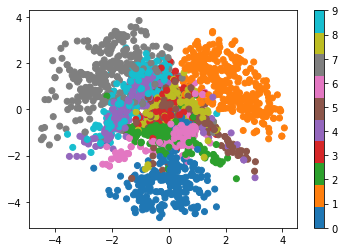

In [33]:
plt.scatter(VAE_latent[:,0],VAE_latent[:,1],c=y_train0[inds],cmap='tab10')
plt.colorbar()

In [34]:
def normalized(x):
    x-=x.min()
    x/=x.max()
    return x

接著，我們進行 Decoder 的視覺化呈現。

In [35]:
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

<function matplotlib.pyplot.show(*args, **kw)>

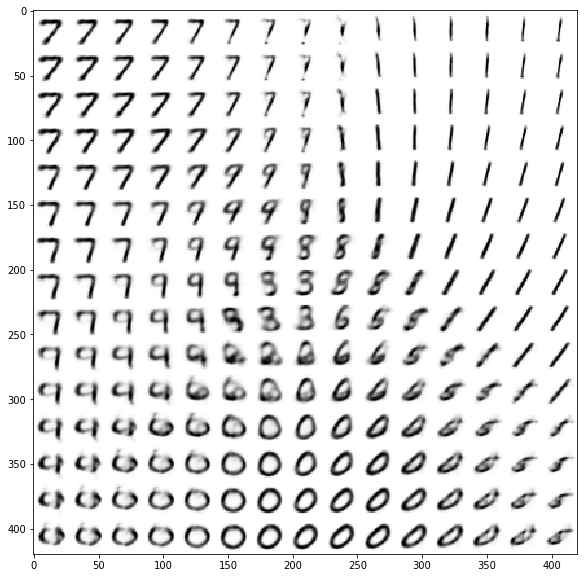

In [36]:
plt.figure(figsize=(10,10))
plt.imshow(VAE_figure,cmap='Greys')
plt.show

## 4.5 與 Autoencoder 的 Encoder 進行視覺化比較

## 4.6 動態比較

In [37]:
def inBetween(t):
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1-t)*x_train0[idx_1] + t*x_train0[idx_2]

    mu_0 = VAE_encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')

In [38]:
idx_1, idx_2 = np.random.randint(x_test.shape[0], size=2)
interact(inBetween, t=FloatSlider(value=0.5,min=0,max=1.0,step=0.02,))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>